In [38]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import PIL.Image as Image 
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

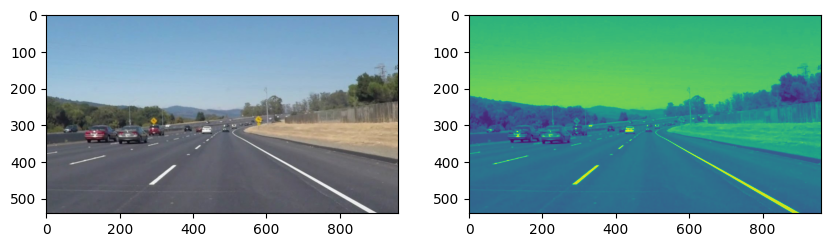

In [39]:
image = cv2.imread('/home/veeransh/Desktop/self-driven-car-ai/Data/straight_line.png')
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
plt.show()

In [40]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
         
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color = [255, 0, 0], thickness = 2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    # img is the output of the canny()
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength = min_line_len, maxLineGap = max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return lines, line_img

In [41]:
rows, cols   = image.shape[:2]
bottom_left  = [int(cols*0.02), int(rows*1)]
top_left     = [int(cols*0.35), int(rows*0.65)]
bottom_right = [int(cols*0.98), int(rows*1)]
top_right    = [int(cols*0.65), int(rows*0.65)]

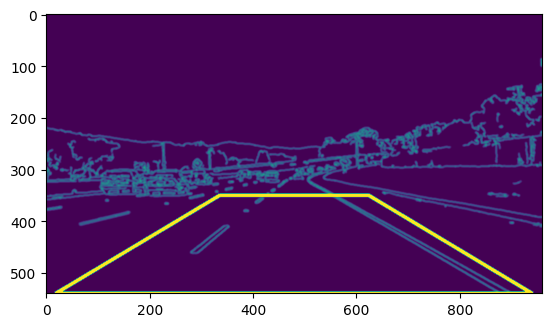

In [42]:
gaussian_7 = gaussian_blur(canny(image, 50, 150),7)
copied = np.copy(gaussian_7)
cv2.line(copied, tuple(bottom_left), tuple(bottom_right), (255,0,0), 5)
cv2.line(copied, tuple(bottom_left), tuple(top_left), (255,0,0), 5)
cv2.line(copied, tuple(top_left), tuple(top_right), (255,0,0), 5)
cv2.line(copied, tuple(top_right), tuple(bottom_right), (255,0,0), 5)
plt.imshow(copied)
plt.show()

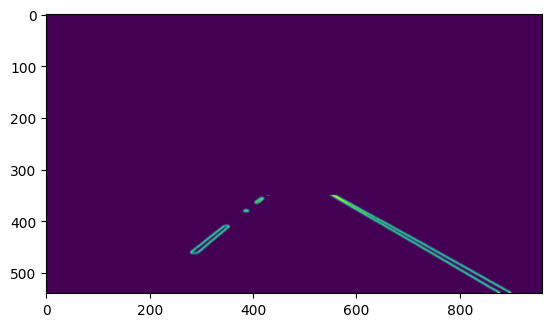

In [43]:
copied = np.copy(gaussian_7)
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
interested = region_of_interest(copied, vertices)
plt.imshow(interested)
plt.show()

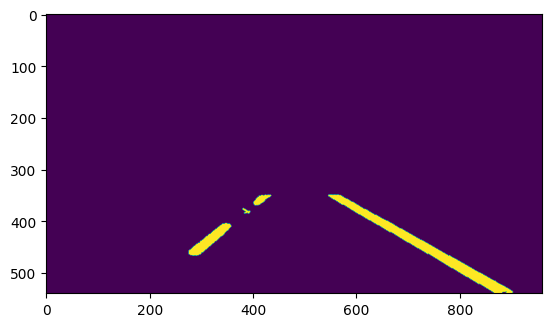

In [44]:
copied = np.copy(gaussian_7)
rho = 1
theta = np.pi / 90
threshold = 5
min_line_length = 10 
max_line_gap = 8
interested = region_of_interest(copied, vertices)
lines,image_lines = hough_lines(interested, rho, theta,threshold,min_line_length,max_line_gap)
plt.imshow(image_lines)
plt.show()

In [45]:
right_sides = {'x':[],'y':[]}
left_sides = {'x':[],'y':[]}
half = image.shape[1]//2
for lane in lines:
    for x1,y1,x2,y2 in lane:
        if x1 < half:
            left_sides['x'].append(x2)
            left_sides['y'].append(y2)
        else:
            right_sides['x'].append(x1)
            right_sides['y'].append(y1)

In [46]:
a_right, b_right = np.polyfit([np.min(right_sides['y']),np.max(right_sides['y'])],
                  [np.min(right_sides['x']),np.max(right_sides['x'])],1)
print(a_right, b_right)
BottomRightX = int(image.shape[0]*a_right+b_right)

a_left, b_left = np.polyfit([np.max(left_sides['y']),np.min(left_sides['y'])],
                  [np.min(left_sides['x']),np.max(left_sides['x'])],1)
print(a_left, b_left)
BottomLeftX = int(image.shape[0]*a_left+b_left)

1.8297872340425523 -95.25531914893583
-1.4653465346534624 948.3366336633652


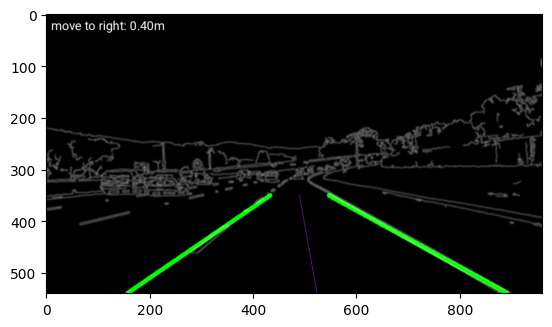

In [47]:
copied = np.copy(image) * 0
color_edges = np.dstack((gaussian_7, gaussian_7, gaussian_7))

TopRightX = np.min(right_sides['x'])
TopRightY = np.min(right_sides['y'])
TopLeftX = np.max(left_sides['x'])
TopLeftY = np.min(left_sides['y'])
if TopRightY < TopLeftY:
    TopLeftY = TopRightY
else:
    TopRightY = TopLeftY

cv2.line(copied,(TopLeftX, TopLeftY),(BottomLeftX, image.shape[0]), (0, 255, 0), 8)
cv2.line(copied,(TopRightX, TopRightY),(BottomRightX, image.shape[0]), (0, 255, 0), 8)

top = (TopLeftX + int((TopRightX - TopLeftX) / 2), TopLeftY)
bottom = (BottomLeftX + int((BottomRightX-BottomLeftX)/2), image.shape[0])
cv2.line(copied,top,bottom, (138,43,226), 1)

ratio_road = int((image.shape[1]-(BottomRightX-BottomLeftX))/2)
steering = (BottomLeftX / ratio_road) - 1

if steering < 0:
    string_steering = 'move to left: %.2fm'%(steering)
else:
    string_steering = 'move to right: %.2fm'%(steering)
    
copied = cv2.addWeighted(color_edges, 0.8, copied, 1, 0)
    
pil_image = Image.fromarray(np.uint8(copied))
draw = ImageDraw.Draw(pil_image)
font = ImageFont.truetype('/home/veeransh/Desktop/self-driven-car-ai/Data/other/Roboto-Regular.ttf', 24)
draw.text((10, 10),string_steering,fill='white',font=font)

plt.imshow(np.array(pil_image))

plt.show()

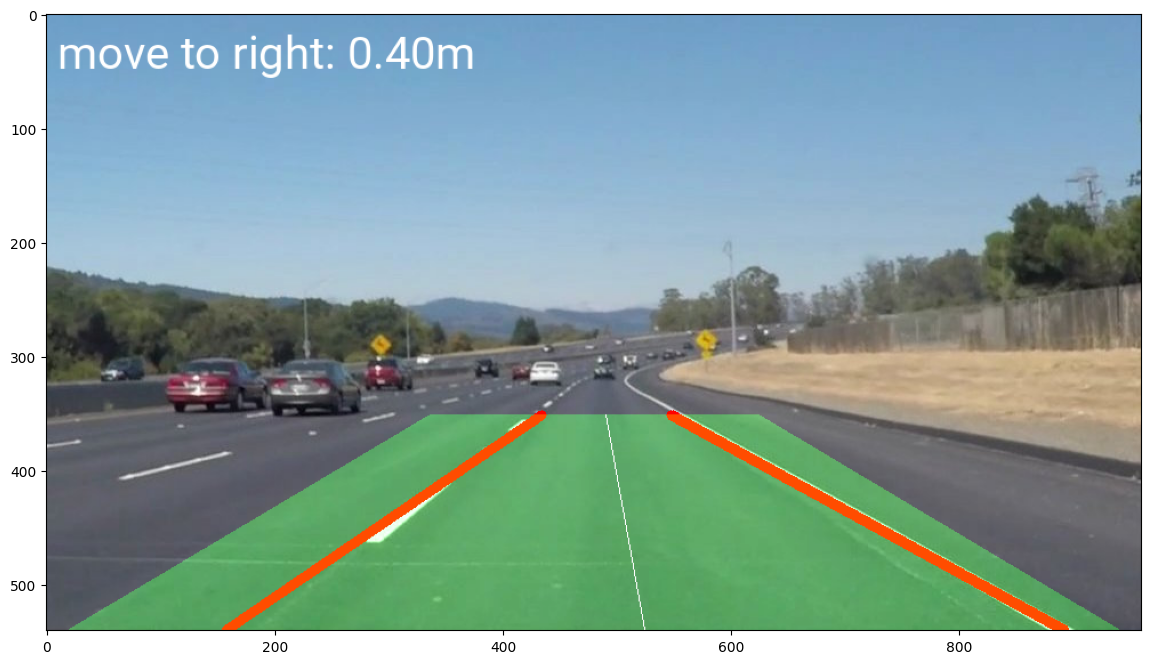

In [48]:


plt.figure(figsize=(15,8))
copied = np.copy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
cv2.line(copied,(TopLeftX, TopLeftY),(BottomLeftX, image.shape[0]), (255, 0, 0), 8)
cv2.line(copied,(TopRightX, TopRightY),(BottomRightX, image.shape[0]), (255, 0, 0), 8)

top = (TopLeftX + int((TopRightX - TopLeftX) / 2), TopLeftY)
bottom = (BottomLeftX + int((BottomRightX-BottomLeftX)/2), image.shape[0])
cv2.line(copied,top,bottom, (255,255,255), 1)

ratio_road = int((image.shape[1]-(BottomRightX-BottomLeftX))/2)
steering = (BottomLeftX / ratio_road) - 1

if steering < 0:
    string_steering = 'move to left: %.2fm'%(steering)
else:
    string_steering = 'move to right: %.2fm'%(steering)
    
window_img = np.zeros_like(copied)
    
polyfill = np.array([bottom_left,bottom_right,top_right,top_left])
cv2.fillPoly(window_img, pts =[polyfill], color=(0,255, 0))
copied = cv2.addWeighted(copied, 1, window_img, 0.3, 0)
    
pil_image = Image.fromarray(np.uint8(copied))
draw = ImageDraw.Draw(pil_image)
font = ImageFont.truetype('/home/veeransh/Desktop/self-driven-car-ai/Data/other/Roboto-Regular.ttf', 40)
draw.text((10, 10),string_steering,fill='white',font=font)

plt.imshow(np.array(pil_image))

plt.show()

In [49]:
%pip install moviepy -q
from moviepy.editor import VideoFileClip
previous_a_right, previous_b_right = 0, 0
previous_a_left, previous_b_left = 0, 0

    pytz (>=2011n)
         ~~~~~~~^
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^
Note: you may need to restart the kernel to use updated packages.


In [55]:
def process_image(image):
    global previous_a_right, previous_b_right, previous_a_left, previous_b_left
    without_smoothing = np.copy(image)
    gray = grayscale(image)
    low_threshold = 100
    high_threshold = 150
    edges = canny(gray, low_threshold, high_threshold)
    kernel_size = 7
    blur_gray = gaussian_blur(edges,kernel_size)
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255
    rows, cols   = image.shape[:2]
    smoothing = 0.95
    bottom_left  = [int(cols*0.02), int(rows*1)]
    top_left     = [int(cols*0.35), int(rows*0.65)]
    bottom_right = [int(cols*0.98), int(rows*1)]
    top_right    = [int(cols*0.65), int(rows*0.65)]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    interested = region_of_interest(edges, vertices)
    rho = 1
    theta = np.pi / 90 
    threshold = 10
    min_line_length = 10
    max_line_gap = 8
    lines = cv2.HoughLinesP(interested, rho, theta, threshold, np.array([]), 
                            minLineLength = min_line_length, maxLineGap = max_line_gap)

    right_sides = {'x':[],'y':[]}
    left_sides = {'x':[],'y':[]}
    half = image.shape[1]//2
    
    for lane in lines:
        for x1,y1,x2,y2 in lane:
            if x1 < half:
                left_sides['x'].append(x2)
                left_sides['y'].append(y2)
            else:
                right_sides['x'].append(x1)
                right_sides['y'].append(y1)
    
    a_right, b_right = np.polyfit([np.min(right_sides['y']),np.max(right_sides['y'])],
                  [np.min(right_sides['x']),np.max(right_sides['x'])],1)

    a_left, b_left = np.polyfit([np.max(left_sides['y']),np.min(left_sides['y'])],
                  [np.min(left_sides['x']),np.max(left_sides['x'])],1)
    
    # for without smoothing
    without_a_right = a_right
    without_b_right = b_right
    without_a_left = a_left
    without_b_left = b_left
    
    if previous_a_right == 0 and previous_b_right == 0:
        previous_a_right = a_right
        previous_b_right = b_right
    else:
        # last * weight + (1 - weight) * point
        a_right = previous_a_right * smoothing + (1 - smoothing) * a_right
        previous_a_right = a_right
        b_right = previous_b_right * smoothing + (1 - smoothing) * b_right
        previous_b_right = b_right
        
    if previous_a_left == 0 and previous_b_left == 0:
        previous_a_left = a_left
        previous_b_left = b_left
    else:
        # last * weight + (1 - weight) * point
        a_left = previous_a_left * smoothing + (1 - smoothing) * a_left
        previous_a_left = a_left
        b_left = previous_b_left * smoothing + (1 - smoothing) * b_left
        previous_b_left = b_left
    
    BottomRightX = int(image.shape[0]*a_right+b_right)
    BottomLeftX = int(image.shape[0]*a_left+b_left)
    
    # for without smoothing
    without_BottomRightX = int(image.shape[0]*without_a_right+without_b_right)
    without_BottomLeftX = int(image.shape[0]*without_a_left+without_b_left)
    
    TopRightX = np.min(right_sides['x'])
    TopRightY = np.min(right_sides['y'])
    TopLeftX = np.max(left_sides['x'])
    TopLeftY = np.min(left_sides['y'])
    
    # for without smoothing
    without_TopRightX = np.min(right_sides['x'])
    without_TopRightY = np.min(right_sides['y'])
    without_TopLeftX = np.max(left_sides['x'])
    without_TopLeftY = np.min(left_sides['y'])
    
    if TopRightY < TopLeftY:
        TopLeftY = TopRightY
        TopLeftX = int(TopLeftY*a_left+b_left)
    else:
        TopRightY = TopLeftY
        TopRightX = int(TopRightY*a_right+b_right)
        
    # for without smoothing
    if without_TopRightY < without_TopLeftY:
        without_TopLeftY = without_TopRightY
        without_TopLeftX = int(without_TopLeftY*without_a_left+without_b_left)
    else:
        without_TopRightY = without_TopLeftY
        without_TopRightX = int(without_TopRightY*without_a_right+without_b_right)
        
    cv2.line(image,(TopLeftX, TopLeftY),(BottomLeftX, image.shape[0]), (255, 0, 0), 8)
    cv2.line(image,(TopRightX, TopRightY),(BottomRightX, image.shape[0]), (255, 0, 0), 8)
    
    # for without smoothing
    cv2.line(without_smoothing,(without_TopLeftX, without_TopLeftY),
             (without_BottomLeftX, image.shape[0]), (255, 0, 0), 8)
    cv2.line(without_smoothing,(without_TopRightX, without_TopRightY),
             (without_BottomRightX, image.shape[0]), (255, 0, 0), 8)

    top = (TopLeftX + int((TopRightX - TopLeftX) / 2), TopLeftY)
    bottom = (BottomLeftX + int((BottomRightX-BottomLeftX)/2), image.shape[0])
    cv2.line(image,top,bottom, (255,255,255), 1)
    
    # for without smoothing
    top = (without_TopLeftX + int((without_TopRightX - without_TopLeftX) / 2), without_TopLeftY)
    bottom = (without_BottomLeftX + int((without_BottomRightX-without_BottomLeftX)/2), image.shape[0])
    cv2.line(without_smoothing,top,bottom, (255,255,255), 1)

    ratio_road = int((image.shape[1]-(BottomRightX-BottomLeftX))/2)
    steering = (BottomLeftX / ratio_road) - 1

    if steering < 0:
        string_steering = 'move to left: %.2fm'%(steering)
    else:
        string_steering = 'move to right: %.2fm'%(steering)
        
    window_img = np.zeros_like(image)
    
    polyfill = np.array([bottom_left,bottom_right,top_right,top_left])
    cv2.fillPoly(window_img, pts =[polyfill], color=(0,255, 0))
    image = cv2.addWeighted(image, 1, window_img, 0.3, 0)
    
    pil_image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.truetype('/home/veeransh/Desktop/self-driven-car-ai/Data/other/Roboto-Regular.ttf', 40)
    draw.text((10, 60),'with smoothing',fill='white',font=font)
    draw.text((10, 10),string_steering,fill='white',font=font)
    
    image = np.array(pil_image)
    
    # for without smoothing
    ratio_road = int((image.shape[1]-(without_BottomRightX-without_BottomLeftX))/2)
    steering = (without_BottomLeftX / ratio_road) - 1

    if steering < 0:
        string_steering = 'move to left: %.2fm'%(steering)
    else:
        string_steering = 'move to right: %.2fm'%(steering)
        
    window_img = np.zeros_like(image)
    
    polyfill = np.array([bottom_left,bottom_right,top_right,top_left])
    cv2.fillPoly(window_img, pts =[polyfill], color=(0,255, 0))
    without_smoothing = cv2.addWeighted(without_smoothing, 1, window_img, 0.3, 0)
    
    pil_image = Image.fromarray(np.uint8(without_smoothing))
    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.truetype('/home/veeransh/Desktop/self-driven-car-ai/Data/other/Roboto-Regular.ttf', 40)
    draw.text((10, 60),'without smoothing',fill='white',font=font)
    draw.text((10, 10),string_steering,fill='white',font=font)
    
    without_smoothing = np.array(pil_image)
    
    return np.concatenate([without_smoothing,image],axis=1)



In [56]:
white_output = '/home/veeransh/Desktop/self-driven-car-ai/Data/testwhite_both.mp4'
clip1 = VideoFileClip("/home/veeransh/Desktop/self-driven-car-ai/Data/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'
